In [36]:
import requests
import urllib.request
import urllib.parse
import unicodedata
from bs4 import BeautifulSoup
import pandas as pd
import re
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

We started by analyzing the html page and locating the data that we need i.e the ranking, country and region, total and international academic stuff, as well as total and international number of students. As mentioned in the homework description the information about the number of staff and students is located in a page other than the one that provides the rank ordering. A redirection to that page is provided by a link on the name of the university and is provided by the root/default/home url suffixed with "/university/some-format-of-the-university-name". Our next task is finding a way to collect the data. 

In order to discover the way the webpage fetches the data we used postman with its interceptor extension, which enabeled us to monitor the requests generated upon every navigation to the given web page. In particular we learned that the data in our interest is returned from an API with a get request to the *data_url* (used in the cell below) in json format. After inspecting the response json object, it has been noticed that all the data displayed on the rankings page originates precisely from this source, and is available in a convinient format. Even more a link to the individual webpage for every university is available, which gives us a way to collect the rest of the data we need. That data though has to be collected by crawling the html response.

In [37]:
# the home URL used for generating the URLs to every individual university site
root_url = 'http://www.topuniversities.com'
# the URL to the API that returns the university data used to generate the table/list of universities (mentioned above)
data_url = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508229310180'
data_request = requests.get(data_url)

In [38]:
# parsing the data and extracting the list of universities from the json
data_json = data_request.json()
ordered_list_of_universities = data_json['data']

Now as we have all that we have all of the data at reach, we just parse it in the following manner. 

First we extract the data available directly in the dictionay such as title, country, region and rank. The rank in particular with using a regex is trimmed from all of the possible nondigit signes present in it, in order to be succesfully parsed as an int as is should be (this is a more general solution that will work in wider spectrum of problems, while our motivation is eliminating the '=' symbols present to indicate a situation where more than one university is given the same rank i.e its a draw).

Next, we use the URL in the dictionary that leads to the individual website for the university, which in turn after crawling it's HTML provides us with the rest of the information we need. After inspection, the nodes in the DOM that contain the numbers of interest are located, and using given CSS selectors manipulated and extracted.

In [39]:
uni_url_request = requests.get("https://www.topuniversities.com/universities/massachusetts-institute-technology-mit")
soup = BeautifulSoup(uni_url_request.text, 'html.parser')

In [41]:
i = 0
university_parsed_data = []
university_parsed_data_url = []
for uni_data in ordered_list_of_universities:
    # This try is present in order to catch any potentional error while parsing and print it nicely
    try: 
        uni_name = uni_data['title']
        uni_country = uni_data['country']
        uni_region = uni_data['region']
        uni_rank = int(re.sub(r'^[^\d]+|[^\d]+$', '', uni_data['rank_display']))
        uni_url = uni_data['url']
        uni_url_name = uni_url.rsplit('/',1)[-1]
        uni_url_request = requests.get("%s%s" % (root_url, uni_url))
        soup = BeautifulSoup(uni_url_request.text, 'html.parser')

        # Usually two objects are selected, since the website has mobile view and desktop view of the table
        # For some universities this information is not available, hence we save the value as -1 to note that
        # In the selection it is noted that all of the numbers of interest are contained in a div with class number, that
        # in turn is always contained in another parent div whose class somehow informs us about its semantical meaning
        # We use the classes and node types in CSS selectors to get the information of interest.
        # The information is trimmed of white spaces and transformed in a suitable format
        total_afs = soup.select('div.total.faculty div.number')
        if len(total_afs) == 0:
            total_afs = -1
        else:
            total_afs = total_afs[0].text.strip().replace(',', '') # total academic faculty stuff
            
        international_afs = soup.select('div.inter.faculty div.number')
        if len(international_afs) == 0:
            international_afs = -1
        else:
            international_afs = international_afs[0].text.strip().replace(',', '') # international academic faculty staff number
        
        total_students = soup.select('div.total.student div.number')
        if len(total_students) == 0:
            total_students = -1
        else:
            total_students = total_students[0].text.strip().replace(',', '') # total number of students

        inter_students = soup.select('div.total.inter div.number')
        if len(inter_students) == 0:
            inter_students = -1
        else:
            inter_students = inter_students[0].text.strip().replace(',', '') # international students number
            
        inter_grad_students_perc = soup.select('div.total.inter div.post span.perc')
        if len(inter_grad_students_perc) == 0:
            inter_grad_students_perc = -1
        else:
            inter_grad_students_perc = int(inter_grad_students_perc[0].text.strip().replace(',', '').replace('%', '')) # international students number
        
        
        # Combine all of the collected data in a concise dictionary, and append it to a list later used to create a dataframe
        university_parsed_data.append({'Rank': uni_rank, 'Name': uni_name, 'Country': uni_country,  'Region': uni_region,
                        'Total_AFS': int(total_afs), 'International_AFS': int(international_afs), 
                        'Total_students': total_students, 'International_students': inter_students})
        university_parsed_data_url.append({'Rank': uni_rank, 'Name': uni_name, 'Country': uni_country,  'Region': uni_region,
                        'Total_AFS': int(total_afs), 'International_AFS': int(international_afs), 
                        'Total_students': total_students, 'International_students': inter_students,
                        'Uni_URL': uni_url_name, 'International_Grads': inter_grad_students_perc*int(inter_students)/100})
    except ValueError as e:
        print(e)
        print("ERROR")
        break
    i += 1
    if i == 200:
        print("SUCCESS")
        break

SUCCESS


In [42]:
# NaN values are set to -1
# There is no university ranked 198, in particular the ranking goes from 3 universities ranked 195 and then continues to 199 
data = pd.DataFrame(university_parsed_data)[['Rank', 'Name', 'Country', 'Region', 
                        'Total_AFS', 'International_AFS', 
                        'Total_students', 'International_students']]
data['Total_students'] = data.Total_students.astype(np.int64)
data['International_students'] = data.International_students.astype(np.int64)
data['Total_AFS'] = data.Total_AFS.astype(np.int64)
data['International_AFS'] = data.International_AFS.astype(np.int64)

data_url = pd.DataFrame(university_parsed_data_url)[['Rank', 'Name', 'Country', 'Region', 
                        'Total_AFS', 'International_AFS', 
                        'Total_students', 'International_students','Uni_URL','International_Grads']]
data_url['Total_students'] = data_url.Total_students.astype(np.int64)
data_url['International_students'] = data_url.International_students.astype(np.int64)
data_url['Total_AFS'] = data_url.Total_AFS.astype(np.int64)
data_url['International_AFS'] = data_url.International_AFS.astype(np.int64)
data_url['International_Grads'] = data_url.International_Grads.astype(np.int64)
data.head()

,Rank,Name,Country,Region,Total_AFS,International_AFS,Total_students,International_students
0,1,Massachusetts Institute of Technology (MIT),United States,North America,2982,1679,11067,3717
1,2,Stanford University,United States,North America,4285,2042,15878,3611
2,3,Harvard University,United States,North America,4350,1311,22429,5266
3,4,California Institute of Technology (Caltech),United States,North America,953,350,2255,647
4,5,University of Cambridge,United Kingdom,Europe,5490,2278,18770,6699


Since it is noticed that some of the part is repetative, a function is defined in order to provent code repetition.

This function gets a *DataFrame* and two *column names*, removes all the rows that contain none in either of them, and than calculates the ratio between the values in these columns for each row of the dataframe, while firstly grouping the data of the dataframe by a given column if a column of the dataframe is passed to the call to group by. The returning DataFrame is sorted by the value of the calculated ratio, which is joined to every row in a column passed as the parameter *new_column_name*. 

It is assumed that the passed *DataFrame* has columns anmed *col1*, *col2* and *group_by* (if used), as well as that the values for *col1*, *col2* are numberic.

In [43]:
def find_ratio(df, col1, col2, new_column_name, group_by=None, ascending=False):
    no_nan_in_columns_df = df[(df[col1] != -1) & (df[col2] != -1)]
    if group_by != None:
        no_nan_in_columns_df = no_nan_in_columns_df.groupby(group_by)[[col1, col2]].sum()
    sorted_ratio = (no_nan_in_columns_df[col1] / no_nan_in_columns_df[col2]).sort_values(ascending=ascending)
    return no_nan_in_columns_df.loc[sorted_ratio.index].join(pd.DataFrame(sorted_ratio, columns=[new_column_name]))

In [44]:
# Calculate the ratio between the number students and staff members, and sort the dataframe according to that value
# It is assumed that the smaller the ratio the better, since there are less students per teacher
find_ratio(data, 'Total_students', 'Total_AFS', 'Ratio', ascending=True).head(10)

,Rank,Name,Country,Region,Total_AFS,International_AFS,Total_students,International_students,Ratio
3,4,California Institute of Technology (Caltech),United States,North America,953,350,2255,647,2.366212
15,16,Yale University,United States,North America,4940,1708,12402,2469,2.510526
5,6,University of Oxford,United Kingdom,Europe,6750,2964,19720,7353,2.921481
4,5,University of Cambridge,United Kingdom,Europe,5490,2278,18770,6699,3.418944
16,17,Johns Hopkins University,United States,North America,4462,1061,16146,4105,3.618557
1,2,Stanford University,United States,North America,4285,2042,15878,3611,3.705484
0,1,Massachusetts Institute of Technology (MIT),United States,North America,2982,1679,11067,3717,3.711268
185,186,University of Rochester,United States,North America,2569,488,9636,2805,3.750876
18,19,University of Pennsylvania,United States,North America,5499,1383,20639,4250,3.753228
17,18,Columbia University,United States,North America,6189,913,25045,8105,4.046696


In [45]:
# Calculate the ratio between the number of international students and  total number of students, sort the dataframe according to that value
# It is assumed that we are interested in the universities that have higher number of international students
find_ratio(data, 'International_students', 'Total_students', 'Ratio').head(10)

,Rank,Name,Country,Region,Total_AFS,International_AFS,Total_students,International_students,Ratio
34,35,London School of Economics and Political Scien...,United Kingdom,Europe,1088,687,9760,6748,0.691393
11,12,Ecole Polytechnique Fédérale de Lausanne (EPFL),Switzerland,Europe,1695,1300,10343,5896,0.570047
7,8,Imperial College London,United Kingdom,Europe,3930,2071,16090,8746,0.543567
198,200,Maastricht University,Netherlands,Europe,1277,502,16385,8234,0.502533
47,47,Carnegie Mellon University,United States,North America,1342,425,13356,6385,0.478062
6,7,UCL (University College London),United Kingdom,Europe,6345,2554,31080,14854,0.477928
91,92,University of St Andrews,United Kingdom,Europe,1140,485,8800,4030,0.457955
41,41,The University of Melbourne,Australia,Oceania,3311,1477,42182,18030,0.427434
126,127,Queen Mary University of London,United Kingdom,Europe,1885,801,16135,6806,0.421816
25,26,The University of Hong Kong,Hong Kong,Asia,3012,2085,20214,8230,0.407144


In [46]:
# Group the data according to the value of the country attribute
# Calculate the ratio between the number of students and staff members, sort the dataframe according to that value
find_ratio(data, 'Total_students', 'Total_AFS', 'Ratio', 'Country', ascending=True).head()

,Total_students,Total_AFS,Ratio
Country,,,
Russia,30233,6709,4.506335
Denmark,67223,11916,5.641407
Saudi Arabia,6040,1062,5.687382
Singapore,58466,9444,6.190809
Malaysia,17902,2755,6.498004


In [47]:
# Group the data according to the value of the country attribute
# Calculate the ratio between the number of international students and total number of students, sort the dataframe according to that value
find_ratio(data, 'International_students', 'Total_students', 'Ratio', 'Country').head()

,International_students,Total_students,Ratio
Country,,,
Australia,106359,301994,0.352189
United Kingdom,199426,583621,0.341705
Hong Kong,24499,78838,0.310751
Austria,19667,63446,0.309980
Switzerland,32995,109112,0.302396


In [48]:
# Group the data according to the value of the region attribute
# Calculate the ratio between the number of students and staff members, sort the dataframe according to that value
find_ratio(data, 'Total_students', 'Total_AFS', 'Ratio', 'Region', ascending=True)

,Total_students,Total_AFS,Ratio
Region,,,
Asia,807003,106734,7.560880
North America,1546353,182123,8.490707
Europe,1957251,218358,8.963496
Latin America,435750,45382,9.601825
Africa,19593,1733,11.305828
Oceania,350167,25347,13.814929


In [49]:
# Group the data according to the value of the region attribute
# Calculate the ratio between the number of international students and total number of students, sort the dataframe according to that value
find_ratio(data, 'International_students', 'Total_students', 'Ratio', 'Region')

,International_students,Total_students,Ratio
Region,,,
Oceania,118798,350167,0.339261
Europe,449364,1957251,0.229589
North America,292116,1546353,0.188906
Africa,3325,19593,0.169703
Asia,110100,807003,0.136431
Latin America,36871,435750,0.084615


### 2. Obtain the 200 top-ranking universities in www.timeshighereducation.com (ranking 2018). Repeat the analysis of the previous point and discuss briefly what you observed.

By analysing the traffic in the browser's inspection tools, it can easily be noticed that when we try to open https://www.timeshighereducation.com, the browser sends a `GET` request for a `JSON` file that contains the entire ranking of universities that is then rendered in the `HTML` of the website. The most practical way of obtaining that information is to use Python to send a request to fetch the `JSON` formatted file from the `URL` we see in the command line tool of the browser.

In [50]:
base_url = 'https://www.timeshighereducation.com'
ranking_data_json_path = '/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'

times_ranking_json = requests.get(base_url + ranking_data_json_path).json()

In [51]:
times_ranking = times_ranking_json['data']

times_ranking_array = []
times_ranking_array_url = []
country_region_mapping = {}
# The case of South Korea needs to be treated manually since the official name of the country is
# Republic of Korea, and it's not recognised by the API service
country_region_mapping['South Korea'] = 'Asia'
for uni_object in times_ranking:
    # Just in case a parsing error occurs
    try:
        # Universities ranked with a range, ex. a–b, can be considered equally ranked as a
        # since that is the most information we can get, but it simplifies the processing
        uni_rank = int(re.sub('=', '', uni_object['rank'].split('–')[0]))
        
        # We need only the top 200 universities
        if uni_rank > 200:
            break
            
        uni_name = uni_object['name']
        uni_country = uni_object['location']
        uni_url = uni_object['url']
        uni_url_name2 = uni_url.rsplit('/',1)[-1]
        # The absolute number of international students is not given, but it can easily be computed
        # based on the percentage of international students and the total number of students 
        uni_total_students = int(re.sub(',', '', uni_object['stats_number_students'])) # Remove the thousands separator
        uni_percentage_international = float(re.sub('%', '', uni_object['stats_pc_intl_students'])) / 100.0
        uni_international_students = int(round(uni_total_students * uni_percentage_international))
        
        # The absolute number of faculty is not given, but there is a student-teacher ratio in the data
        # which is basically the number of students divided by the number of staff, so a formula can be derived
        # The numbers differ greatly from what has been observed from the first data source
        uni_student_faculty_ratio = float(uni_object['stats_student_staff_ratio'])
        uni_total_staff = int(round(uni_total_students / uni_student_faculty_ratio))
        
        # The region of the university is not given in the data, but there is a very simple public API
        # that can be used to fetch the region information based on the country name, called Rest Countries
        rest_country_url = "https://restcountries.eu/rest/v2/name/%s?fields=region" % urllib.request.pathname2url(uni_country)
        # Cache the results instead of sending GET requests all the time
        if uni_country in country_region_mapping:
            uni_region = country_region_mapping[uni_country]
        else:
            uni_region_raw = requests.get(rest_country_url).json()
            uni_region = None
            # If it's not a list then it's an error and the region could not be found
            if type(uni_region_raw) is list:
                uni_region = uni_region_raw[0]['region']
            # Cache the new result
            country_region_mapping[uni_country] = uni_region
        
        times_ranking_array.append({
            'Rank': uni_rank,
            'Name': uni_name,
            'Country': uni_country,
            'Region': uni_region,
            'International_faculty': None,
            'Total_faculty': uni_total_staff,
            'International_students': uni_international_students,
            'Total_students': uni_total_students
        })
        
        times_ranking_array_url.append({
            'Rank': uni_rank,
            'Name': uni_name,
            'Country': uni_country,
            'Region': uni_region,
            'International_faculty': None,
            'Total_faculty': uni_total_staff,
            'International_students': uni_international_students,
            'Total_students': uni_total_students,
            'Uni_URL': uni_url_name2
        })
        
    except ValueError as e:
        print(e)
        print("ERROR")
        break

In [52]:
times_ranking_df = pd.DataFrame(times_ranking_array)[['Rank', 'Name', 'Country', 'Region',
                                                      'Total_faculty', 'International_faculty',
                                                      'Total_students', 'International_students']]
times_ranking_url_df = pd.DataFrame(times_ranking_array_url)[['Rank', 'Name', 'Country', 'Region',
                                                      'Total_faculty', 'International_faculty',
                                                      'Total_students', 'International_students','Uni_URL']]
times_ranking_df.head()

,Rank,Name,Country,Region,Total_faculty,International_faculty,Total_students,International_students
0,1,University of Oxford,United Kingdom,Europe,1822,None,20409,7755
1,2,University of Cambridge,United Kingdom,Europe,1687,None,18389,6436
2,3,California Institute of Technology,United States,Americas,340,None,2209,596
3,3,Stanford University,United States,Americas,2113,None,15845,3486
4,5,Massachusetts Institute of Technology,United States,Americas,1285,None,11177,3800


The data that Times Higher Education ranking website provides is not as informative as the one from Top Universities, especially in the categories that are requested in the assignment. It is worse in terms that it does not contain raw data and raw numbers, but aggregated ones or data that has already undergone some processing and calculations.

For example: 
* the number of international students is given as a percentage of the total number, so the absolute value needs to be computed. 
* there is no information about international faculty (or staff) at the universities, neither as raw data nor percentage, i.e. there is no way to deduce or calculate the number
* there is no region information for a particular university or country, therefore another source of information was needed, that might not provide the exact same region labels as Top Universities, but in the end the numbers in the groupings are easily comparable
* it was necessary to compute the total faculty based on the number of students and the student-teacher ratio using the following relationship between the variables:
$$student\_teacher\_ratio = \frac{\#students}{\#staff}$$

** Best universities in terms of: ratio between faculty members and students **

In [53]:
# Calculate the student teacher ratio
# It is assumed that the smaller the ratio the better, since there are less students per teacher
find_ratio(times_ranking_df, 'Total_students', 'Total_faculty', 'Student_teacher_ratio', ascending=True).head(10)

,Rank,Name,Country,Region,Total_faculty,International_faculty,Total_students,International_students,Student_teacher_ratio
105,105,Vanderbilt University,United States,Americas,3640,None,12011,1561,3.299725
109,109,University of Copenhagen,Denmark,Europe,7413,None,30395,4255,4.100229
11,12,Yale University,United States,Americas,2827,None,12155,2553,4.299611
153,153,University of Rochester,United States,Americas,2241,None,9636,2794,4.299866
12,13,Johns Hopkins University,United States,Americas,3604,None,15498,3720,4.300222
97,98,Emory University,United States,Americas,2875,None,12649,2403,4.399652
16,17,Duke University,United States,Americas,3390,None,15256,3356,4.500295
114,115,École Polytechnique,France,Europe,549,None,2799,1008,5.098361
183,184,Scuola Normale Superiore di Pisa,Italy,Europe,99,None,515,36,5.202020
101,100,University of Pittsburgh,United States,Americas,4469,None,26367,2637,5.899978


Even though the ratio numbers are very off, Yale University, Johns Hopkins University and University of Rochester, all in the US, are among the best 10 according to student-teacher-ratio.

** Best universities in terms of: ratio of international students **

In [54]:
# Calculate the ratio between the number of international students and total number of students
# and sort the dataframe according to that value
# It is assumed that we are interested in the universities that have high percentage of international students
find_ratio(times_ranking_df, 'International_students', 'Total_students', 'Internationality_ratio').head(10)

,Rank,Name,Country,Region,Total_faculty,International_faculty,Total_students,International_students,Internationality_ratio
24,25,London School of Economics and Political Science,United Kingdom,Europe,825,None,10065,7146,0.709985
178,179,University of Luxembourg,Luxembourg,Europe,340,None,4969,2832,0.569934
7,8,Imperial College London,United Kingdom,Europe,1391,None,15857,8721,0.549978
37,38,École Polytechnique Fédérale de Lausanne,Switzerland,Europe,886,None,9928,5460,0.549960
102,103,Maastricht University,Netherlands,Europe,929,None,16727,8364,0.500030
15,16,University College London,United Kingdom,Europe,2886,None,30304,14849,0.490001
143,143,University of St Andrews,United Kingdom,Europe,693,None,9005,4322,0.479956
23,24,Carnegie Mellon University,United States,Americas,939,None,12676,5704,0.449984
120,121,Queen Mary University of London,United Kingdom,Europe,1158,None,15405,6932,0.449984
39,40,University of Hong Kong,Hong Kong,Asia,1020,None,18364,7713,0.420007


Both sources confirm that *London School of Economics and Political Science* is at the top of being the most international, with a large 70% of students being from outside of the UK. Among the top 10 on both lists are also:
* EPFL
* Carnegie Mellon University
* Imperial College London
* University Colege London
* Maastricht University
* Queen Mary University of London
* University of St. Andrews
* University of Hong Kong

University of Luxembourg is missing in the second list event though it is very highly ranked in the first one according to the above mentioned criterion.

** Best universities in terms of: ratio between faculty members and students grouped by country **

In [55]:
# Group the data according to the value of the country attribute
# Calculate the ratio between the number of students and staff members, sort the dataframe according to that value
find_ratio(times_ranking_df, 'Total_students', 'Total_faculty', 'Student_teacher_ratio', 'Country', ascending=True).head(5)

,Total_students,Total_faculty,Student_teacher_ratio
Country,,,
Denmark,64110,10598,6.049255
Russian Federation,29236,4005,7.299875
Japan,48481,6465,7.498995
Italy,1205,158,7.626582
Switzerland,107852,10049,10.732610


Even though there is a big difference between the university faculty numbers from both data sources, both lists agree that the top 2 countries according to this criterion are Denmark and Russia.

** Best universities in terms of: ratio of international students grouped by country **

In [56]:
# Group the data according to the value of the country attribute
# Calculate the ratio between the number of international students and total number of students
# sort the dataframe according to that value
find_ratio(times_ranking_df, 'International_students', 'Total_students', 'Internationality_ratio', 'Country').head(5)

,International_students,Total_students,Internationality_ratio
Country,,,
Luxembourg,2832,4969,0.569934
United Kingdom,213058,596449,0.357211
Hong Kong,25158,77663,0.323938
Australia,83812,268630,0.311998
Singapore,17086,56101,0.304558


The United Kingdom and Hong Kong are second and third on both lists with a very similar ratio, respectively. Luxembourg has a huge internationality ratio according to the first source, but it didn't make it to the list in the second. Australia is also among the top 5 on both rankings, but the ratio differs by a few points.

** Best universities in terms of: ratio between faculty members and students grouped by region **

In [57]:
# Group the data according to the value of the region attribute
# Calculate the ratio between the number of students and staff members, sort the dataframe according to that value
find_ratio(times_ranking_df, 'Total_students', 'Total_faculty', 'Student_teacher_ratio', 'Region', ascending=True)

,Total_students,Total_faculty,Student_teacher_ratio
Region,,,
Africa,20775,1776,11.697635
Americas,1954934,165594,11.805585
Asia,530949,42636,12.453068
Europe,2143623,126864,16.897016
Oceania,298978,11554,25.876580


Note that there are two reasons this table is difficult to comment:
1. the large difference in the raw data about staff members for each university, which makes figures difficult to compare
2. the second source aggregates North and South America into a single region, so the values are aggregated

** Best universities in terms of: ratio of international students grouped by region **

In [58]:
# Group the data according to the value of the region attribute
# Calculate the ratio between the number of international students and total number of students, sort the dataframe according to that value
find_ratio(times_ranking_df, 'International_students', 'Total_students', 'Internationality_ratio', 'Region')

,International_students,Total_students,Internationality_ratio
Region,,,
Oceania,92613,298978,0.309765
Europe,481576,2143623,0.224655
Africa,3740,20775,0.180024
Americas,336271,1954934,0.172011
Asia,78839,530949,0.148487


The aggregated tables according to the ratio of international students are pretty much identical from both sources, with some small differences in the ratio values. Once North America and South America are averaged in the first case, it will easily be seen a ratio close to 0.17 is obtained.

Overall, the most noticeable characteristic in the data is the big discrepancy between the student-to-faculty ratio computed from the first source and the second one. And since there is no staff number information in the second source, it's impossible to detect the source or reason for this big difference.

In the second dataset, there is a tendency of a very large student-to-staff ratio value, which after doing the calculations results in significantly fewer staff members per university, as compared to the first source. Therefore, it is understandable that all the derived and aggregated results will differ, somewhere even relatively greatly. However, there is no way to judge which of the two is more reliable without obtaining additional information from another external source.

### 3. Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

The merging of the two datasets is tricky because we have observed that they dont follow the same format. For example:
1. There are universities included in one of the lists but not in the other.
2. The same university has different names in the two ranging lists.
3. There is punctuation that differs between the two lists.
4. The same university is written in different languages in the two lists.
5. There are brackets with initials of the universities in the topuniversities list.
6. There is regional specification in the name of the univeristies. (e.g at Berlin)
7. There are accent letters in some of the universities' names
8. There are different punctuation symbols for the same reason as apostrophe

We decided that as a first coarsening phase it would be good to merge the two lists not according the name but add a new column that refers to the url of the univerisities. We observed that in url's the names of the universities are already firstly in lower case. Moreover the punctuation in the urls is avoided so the number of universities that can be merged together is increasing. Furthermore the accent letters in the urls are encoded in a percentage format and we can manipulate them in python by decoding and normalizing them to match in both lists. Last but not least we manually change the name of some universities as they might be in different language and also have more specific names (e.g) and we dont have an automatic way to figure out how to infer such an information.

In [59]:
data_url.head()

,Rank,Name,Country,Region,Total_AFS,International_AFS,Total_students,International_students,Uni_URL,International_Grads
0,1,Massachusetts Institute of Technology (MIT),United States,North America,2982,1679,11067,3717,massachusetts-institute-technology-mit,3085
1,2,Stanford University,United States,North America,4285,2042,15878,3611,stanford-university,2997
2,3,Harvard University,United States,North America,4350,1311,22429,5266,harvard-university,4476
3,4,California Institute of Technology (Caltech),United States,North America,953,350,2255,647,california-institute-technology-caltech,562
4,5,University of Cambridge,United Kingdom,Europe,5490,2278,18770,6699,university-cambridge,4287


In [60]:
times_ranking_url_df.head()

,Rank,Name,Country,Region,Total_faculty,International_faculty,Total_students,International_students,Uni_URL
0,1,University of Oxford,United Kingdom,Europe,1822,None,20409,7755,university-oxford
1,2,University of Cambridge,United Kingdom,Europe,1687,None,18389,6436,university-cambridge
2,3,California Institute of Technology,United States,Americas,340,None,2209,596,california-institute-technology
3,3,Stanford University,United States,Americas,2113,None,15845,3486,stanford-university
4,5,Massachusetts Institute of Technology,United States,Americas,1285,None,11177,3800,massachusetts-institute-technology


<b>Step 1</b>
The first problem is that some letters of the universities are in the local language. However taking the urls as we said gives us the possibility to recognise these letters as they are represented in the url encoding. So we firstly clean the data from the first ranking list where these things exist and we convert the url encoding to ascii in order to have match with the urls of the second list.

In [61]:
#Change the values of the Uni_URL fields from url encoding to ASCII encoding without accent letters
def encoding_conversion(input_string):
    url_decoded = urllib.parse.unquote(input_string)
    normalized = unicodedata.normalize('NFKD', url_decoded)
    final_url = normalized.encode('ASCII', 'ignore').decode("ASCII")
    return final_url

#Some urls have -0, -1 because the site had more references on the same university
def eliminate_dupl_digit(uni_name):
    if uni_name.rsplit('-',1)[-1].isdigit():
        return uni_name.rsplit('-',1)[:-1][0]
    else:
        return uni_name

data_url['Uni_URL'] = data_url['Uni_URL'].apply(lambda x: encoding_conversion(x))
#writer = pd.ExcelWriter('top.xlsx', engine='xlsxwriter')
# Convert the dataframe to an XlsxWriter Excel object.
#data_url.to_excel(writer, sheet_name='Sheet1')
# Close the Pandas Excel writer and output the Excel file.
#writer.save()
times_ranking_url_df['Uni_URL'] = times_ranking_url_df['Uni_URL'].apply(lambda x: eliminate_dupl_digit(x))
#data_url
#writer = pd.ExcelWriter('times.xlsx', engine='xlsxwriter')
# Convert the dataframe to an XlsxWriter Excel object.
#times_ranking_url_df.to_excel(writer, sheet_name='Sheet1')
# Close the Pandas Excel writer and output the Excel file.
#writer.save()

<b>Step 2</b>
The second problem is that in the first lists the universities do have also their initials in their names but also in the Url's. With the url's we already avoided some punctuation problems that we had.(e.g King's College) and some propositions as (e.g : at). However to solve the problem of initials in brackets we merge on a partially match string of the url. If the seconds list university's url is contained in the first's lists university's urls then we should merge them together. We first build a list of these matches and we check for empty matches in the list. These empty matches will be referring to different problems that probably cannot be solved automatically and we should solve them manually. For example totally different names for the same university as one can be the official name and the other could be the promoted name of the university.

In [62]:
times_ranking_url_df.loc[times_ranking_url_df['Uni_URL'] == 'eth-zurich-swiss-federal-institute-technology-zurich', 'Uni_URL'] = 'eth-zurich-swiss-federal-institute-technology'
times_ranking_url_df.loc[times_ranking_url_df['Uni_URL'] == 'london-school-economics-and-political-science', 'Uni_URL'] = 'london-school-economics-political-science-lse'
times_ranking_url_df.loc[times_ranking_url_df['Uni_URL'] == 'lmu-munich', 'Uni_URL'] = 'ludwig-maximilians-universitat-munchen'
times_ranking_url_df.loc[times_ranking_url_df['Uni_URL'] == 'heidelberg-university', 'Uni_URL'] = 'ruprecht-karls-universitat-heidelberg'
data_url.loc[data_url['Uni_URL'] == 'humboldt-universitat-zu-berlin', 'Uni_URL'] = 'humboldt-university-berlin'
times_ranking_url_df.loc[times_ranking_url_df['Uni_URL'] == 'wageningen-university-research', 'Uni_URL'] = 'wageningen-university'
times_ranking_url_df.loc[times_ranking_url_df['Uni_URL'] == 'university-freiburg', 'Uni_URL'] = 'albert-ludwigs-universitaet-freiburg'
times_ranking_url_df.loc[times_ranking_url_df['Uni_URL'] == 'free-university-berlin', 'Uni_URL'] = 'freie-universitaet-berlin'
times_ranking_url_df.loc[times_ranking_url_df['Uni_URL'] == 'technical-university-berlin', 'Uni_URL'] = 'technische-universitat-berlin-tu-berlin'
times_ranking_url_df.loc[times_ranking_url_df['Uni_URL'] == 'university-tubingen', 'Uni_URL'] = 'eberhard-karls-universitat-tubingen'
times_ranking_url_df.loc[times_ranking_url_df['Uni_URL'] == 'korea-advanced-institute-science-and-technology-kaist', 'Uni_URL'] = 'kaist-korea-advanced-institute-science-technology'
times_ranking_url_df.loc[times_ranking_url_df['Uni_URL'] == 'university-montreal', 'Uni_URL'] = 'universite-de-montreal'
times_ranking_url_df.loc[times_ranking_url_df['Uni_URL'] == 'pierre-and-marie-curie-university', 'Uni_URL'] = 'universite-pierre-et-marie-curie-upmc'
times_ranking_url_df.loc[times_ranking_url_df['Uni_URL'] == 'university-science-and-technology-china', 'Uni_URL'] = 'university-science-technology-china'
times_ranking_url_df.loc[times_ranking_url_df['Uni_URL'] == 'autonomous-university-barcelona', 'Uni_URL'] = 'universitat-autonoma-de-barcelona'
times_ranking_url_df.loc[times_ranking_url_df['Uni_URL'] == 'pohang-university-science-and-technology', 'Uni_URL'] = 'pohang-university-science-technology-postech'
times_ranking_url_df.loc[times_ranking_url_df['Uni_URL'] == 'hong-kong-university-science-and-technology', 'Uni_URL'] = 'hong-kong-university-science-technology'
times_ranking_url_df.loc[times_ranking_url_df['Uni_URL'] == 'university-hong-kong', 'Uni_URL'] = 'university-hong-kong-hku'
data_url.loc[data_url['Uni_URL'] == 'university-hong-kong', 'Uni_URL'] = 'university-hong-kong-hku'
times_ranking_url_df.loc[times_ranking_url_df['Uni_URL'] == 'ecole-polytechnique', 'Uni_URL'] = 'ecole-polytechnique-paris'
data_url.loc[data_url['Uni_URL'] == 'ecole-polytechnique', 'Uni_URL'] = 'ecole-polytechnique-paris'

Above we can see the universities that dont match for many reasons. Or the ones that match with more than one university of the other list and thus we have overlap. As we said the reason why can be different language or non-existence in the other list. So in order to eliminate all these conflicts we will proceed manually. We will proceed in changing the url representation of some institutions in the list. Anyway we dont need the information of url as its not even the real url but a relational path of the host page.

In [63]:
matches = [(data_url[data_url['Uni_URL'].str.contains(x)],x) for x in times_ranking_url_df['Uni_URL']]

cleaned_matches = []
for (i,j) in matches:
    if i.empty == False:
        cleaned_matches.append((i,j))
matched_idx = [(x.index.values[0],y) for x,y in cleaned_matches]
data_url
for (x,y) in matched_idx:
    #print (x,y)
    data_url.loc[int(x),'Uni_URL'] = y

partial = pd.Series(data=times_ranking_url_df['Uni_URL'],index=matched_idx)

total = data_url.merge(times_ranking_url_df, on = 'Uni_URL', how='inner',suffixes=('_top', '_times')).drop('Uni_URL',axis='columns').drop('International_faculty',axis = 'columns')
total

,Rank_top,Name_top,Country_top,Region_top,Total_AFS,International_AFS,Total_students_top,International_students_top,International_Grads,Rank_times,Name_times,Country_times,Region_times,Total_faculty,Total_students_times,International_students_times
0,1,Massachusetts Institute of Technology (MIT),United States,North America,2982,1679,11067,3717,3085,5,Massachusetts Institute of Technology,United States,Americas,1285,11177,3800
1,2,Stanford University,United States,North America,4285,2042,15878,3611,2997,3,Stanford University,United States,Americas,2113,15845,3486
2,3,Harvard University,United States,North America,4350,1311,22429,5266,4476,6,Harvard University,United States,Americas,2284,20326,5285
3,4,California Institute of Technology (Caltech),United States,North America,953,350,2255,647,562,3,California Institute of Technology,United States,Americas,340,2209,596
4,5,University of Cambridge,United Kingdom,Europe,5490,2278,18770,6699,4287,2,University of Cambridge,United Kingdom,Europe,1687,18389,6436
5,6,University of Oxford,United Kingdom,Europe,6750,2964,19720,7353,5441,1,University of Oxford,United Kingdom,Europe,1822,20409,7755
6,7,UCL (University College London),United Kingdom,Europe,6345,2554,31080,14854,8169,16,University College London,United Kingdom,Europe,2886,30304,14849
7,8,Imperial College London,United Kingdom,Europe,3930,2071,16090,8746,4635,8,Imperial College London,United Kingdom,Europe,1391,15857,8721
8,9,University of Chicago,United States,North America,2449,635,13557,3379,2568,9,University of Chicago,United States,Americas,2181,13525,3381
9,10,ETH Zurich - Swiss Federal Institute of Techno...,Switzerland,Europe,2477,1886,19815,7563,5445,10,ETH Zurich – Swiss Federal Institute of Techno...,Switzerland,Europe,1317,19233,7309


### 4. Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

For finding the correlation between the rank of the universities and their features in each list we visualize in a bar chart each feature that is available with each other. We do that for both lists and we infer some possible results.

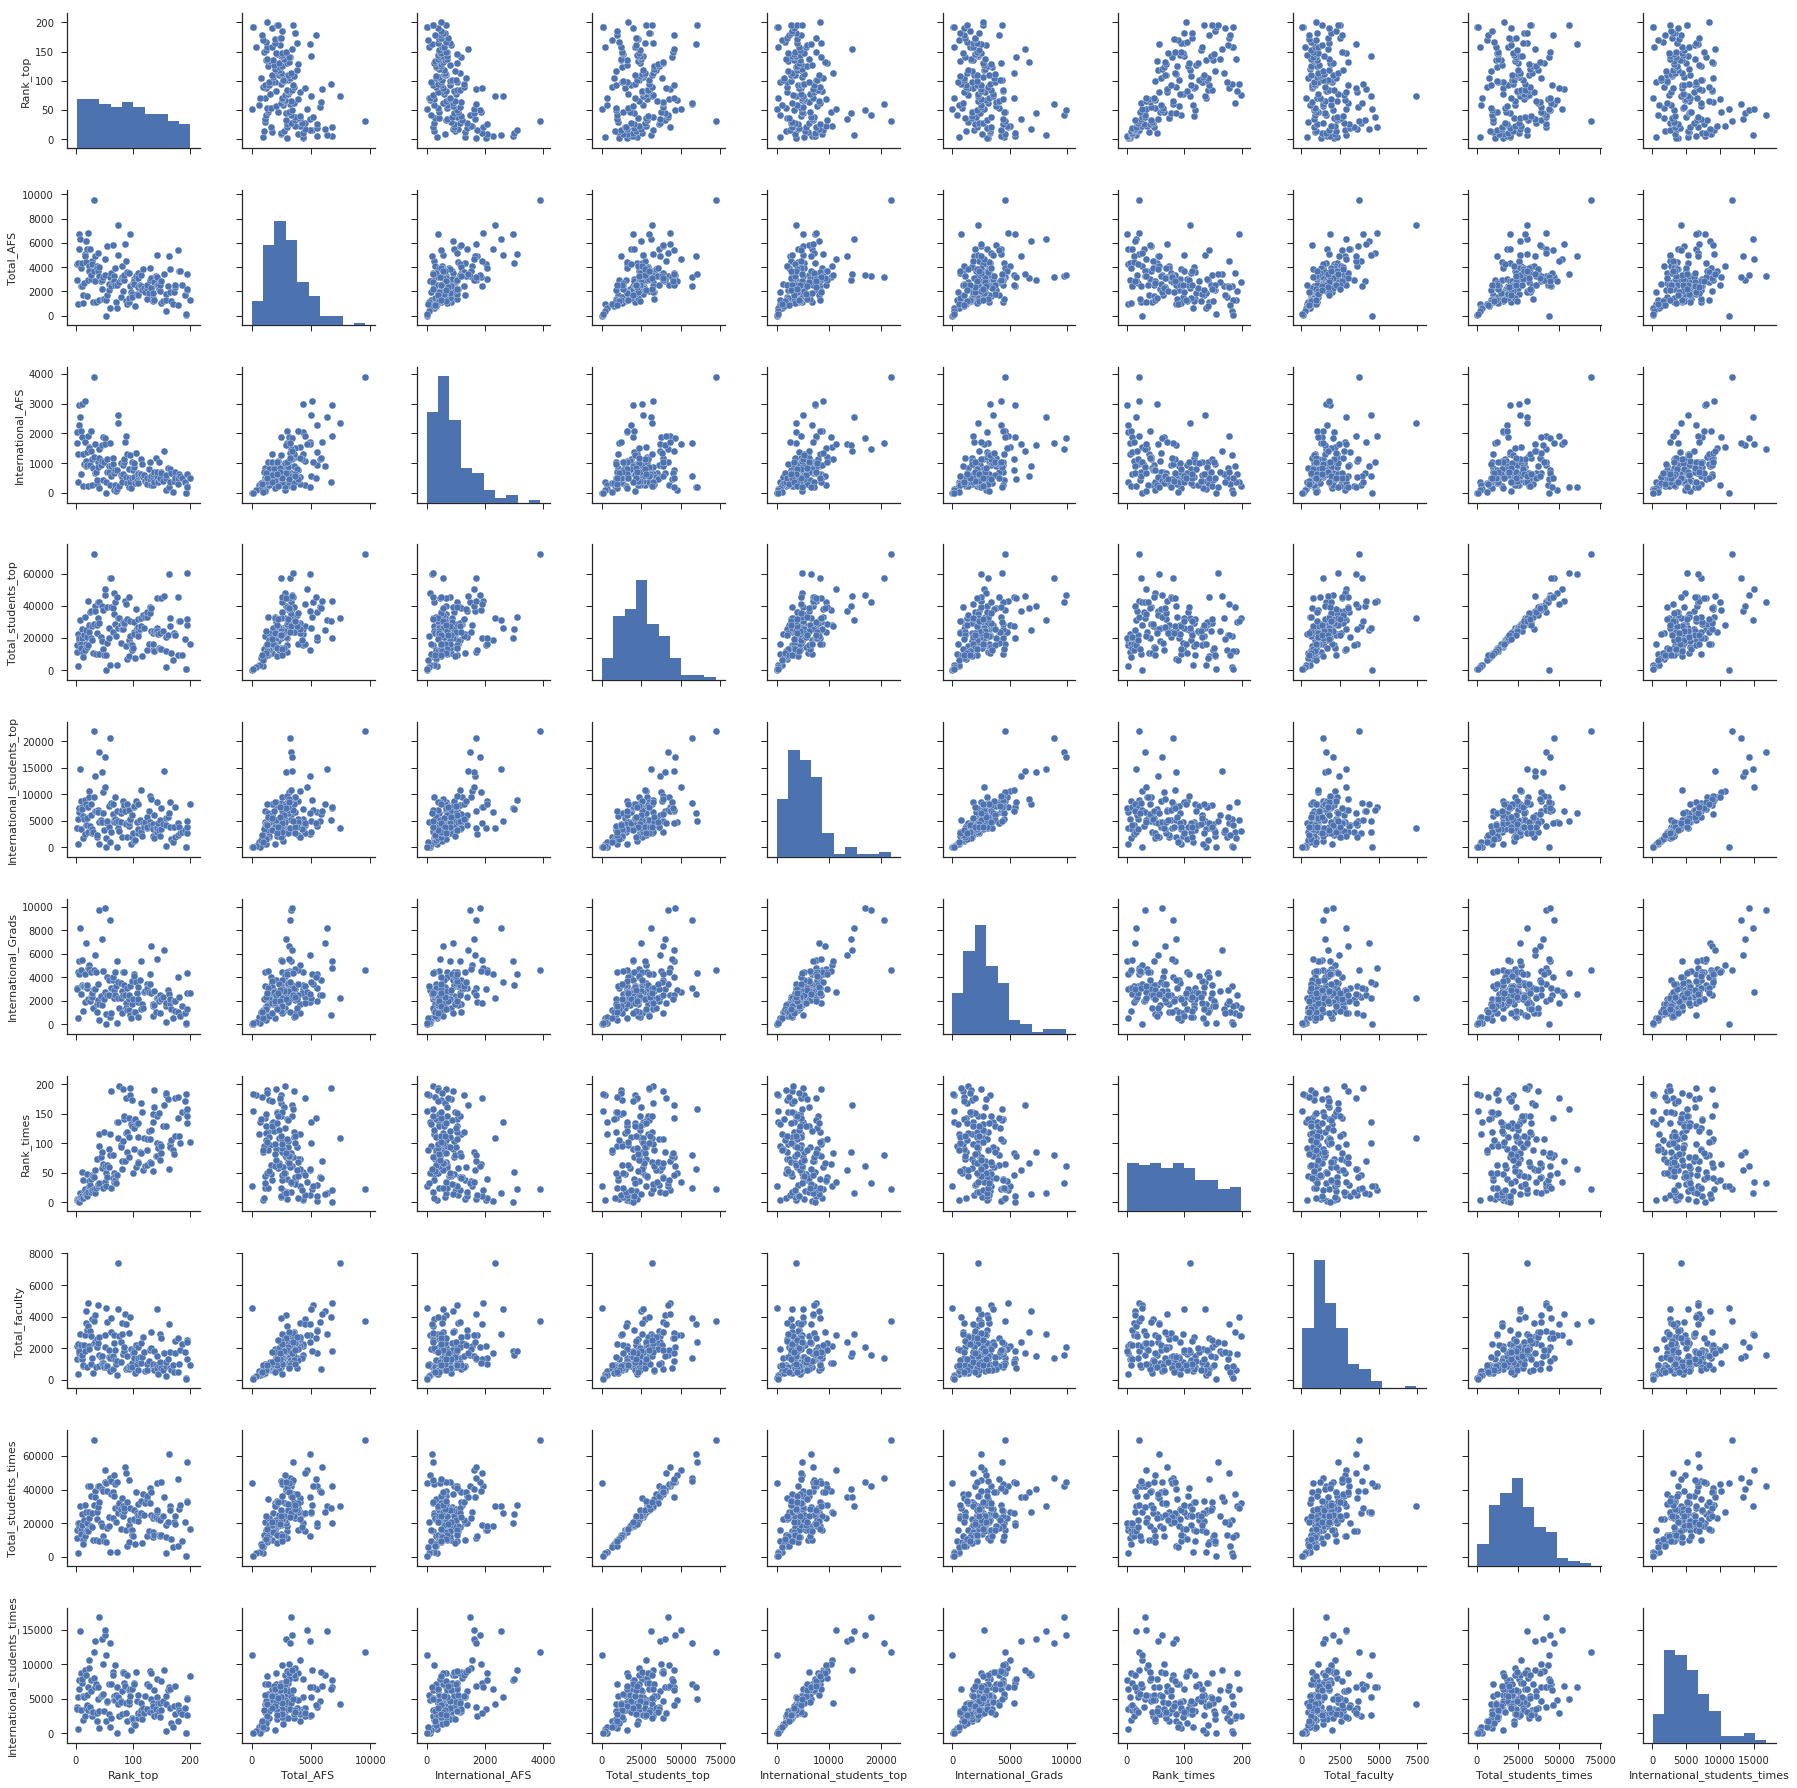

In [64]:
import seaborn as sns
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(total)

From the previous correlations plots it was easy to distinct a correlation between the number of international_AFS (Academic Faculty & Staff) with the ranking of the universities. It seems from the barplot below that the top ranked universities have far more higher mean value of international faculty & staff number than the universities that fill the rest places in the ranking list. However the result is logical as in these rankings -according the methodology that they follow- the number of international staff plays a quite important role as a percentage of the ranking calculation.

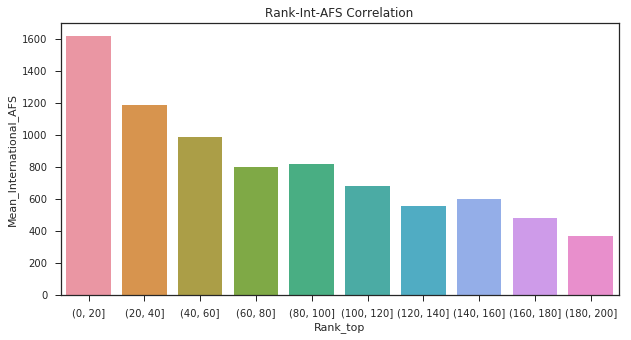

In [65]:
plot_df = total.copy()

plot_df['Rank_top'] = pd.cut(plot_df['Rank_top'], [0,20,40,60,80,100,120,140,160,180,200])
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='Rank_top',y='International_AFS', data=plot_df,ci=None)
plt.xlabel('Rank_top')
plt.ylabel('Mean_International_AFS')
plt.title('Rank-Int-AFS Correlation')
plt.show()

We noticed a serious inconcistency between the features of the two merged dataframes. The total number of AFS is seriously lower in the data coming from 'times' ranking than the 'top' ones. After some analysis and research we found out that the cause of that is the different approach of the two rankings systems. First of all the data source of these rankings are not the same. In the "top" list it seems that they consider as faculty and staff also members of the council etc. On the other hand in "times" list we dont have access to the criteria of the faculty selection but with a further research on the universities websites we found out that the "times" ranking numbers are close to the ones that the universities give away for teaching and research staff only and not other academic positions.

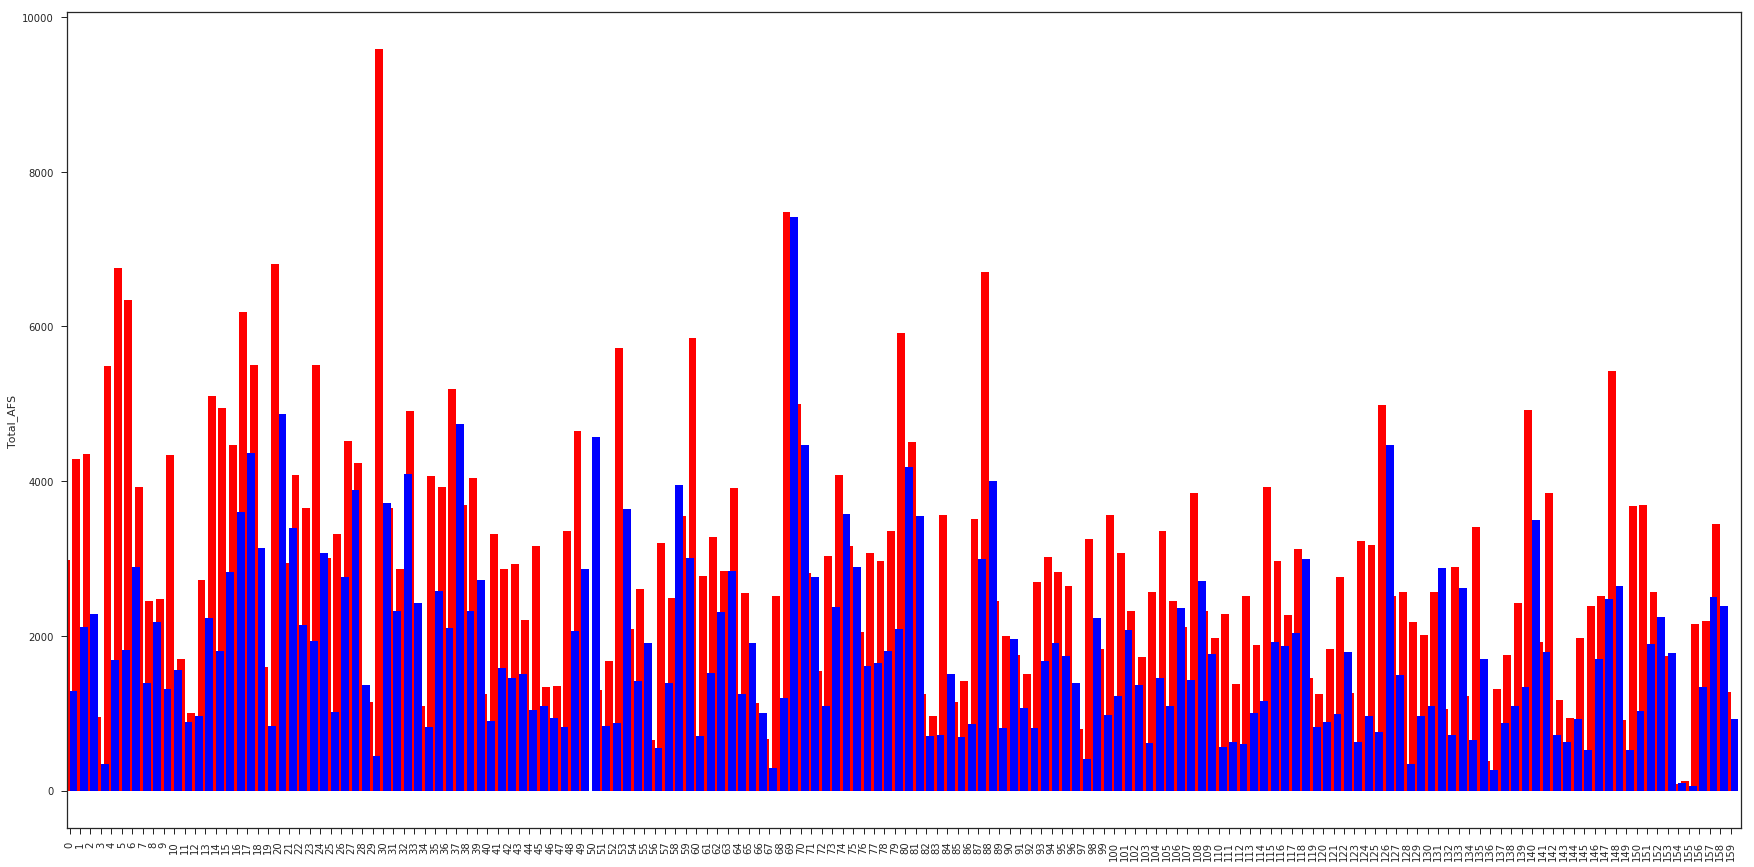

In [66]:
plot_df = total.copy()

fig, ax = plt.subplots(figsize=(30,15))
total.Total_AFS.plot(kind='bar', color='red', ax=ax, width=0.75, position=1)
total.Total_faculty.plot(kind='bar', color='blue', ax=ax, width=0.75, position=0)

ax.set_ylabel('Total_AFS')

plt.show()


After the international faculty and stuff correlation that we observed, we thought as a good idea, given that in the rankings they promote universities with a good ration of AFS : students, that the mean value of number of total AFS of the top universities will have also some correlation with the ranking. The plot below confirms that but not in a such good and robust way as the corralation between international stuff and ranking.

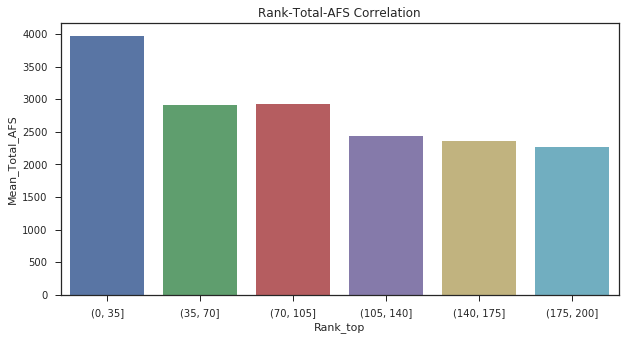

In [67]:
plot_df = total.copy()
#[0,35,70,105,140,175,200]
plot_df['Rank_top'] = pd.cut(plot_df['Rank_top'], [0,35,70,105,140,175,200])
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='Rank_top',y='Total_AFS', data=plot_df,ci=None)
plt.xlabel('Rank_top')
plt.ylabel('Mean_Total_AFS')
plt.title('Rank-Total-AFS Correlation')
plt.show()

From the above pairwise correlation plot we couldn't noticed for the merged dataframe any other obvious strong correlation so we thought that due to the fact that rankings grade also the research in a very generous way, it would be a good idea to add to our datafrmae also the information, that refers to the number of the international grads students and postgraduates for each university. The reason why we thought that there will be a correlation was simple. These category of people (postgraduates international students) contribute in two categories of the ranking systems.The on of internationality and the other of research contribution as they have already graduated and they might probably work on research. However according to the results that we took there is no so much correlation between these two field as the number of international grads might depend also in some other factors that we dont know, but it might be also the country of university, the legislation, etc...

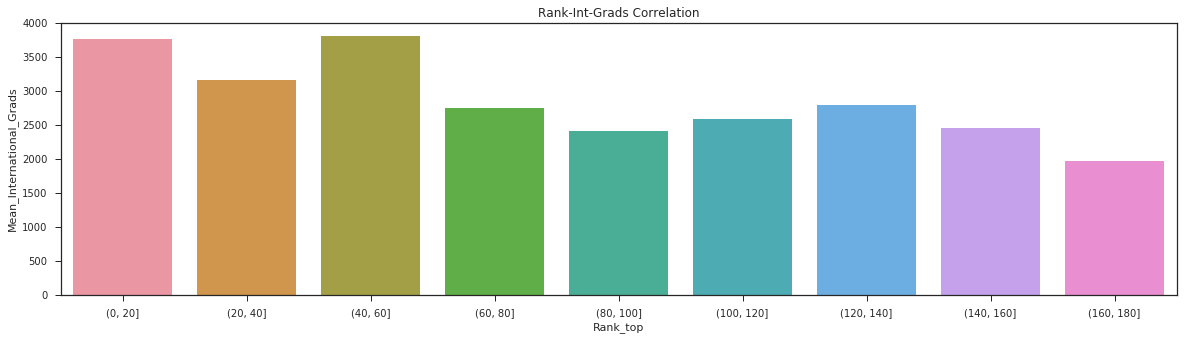

In [68]:
plot_df = total.copy()


plot_df['Rank_top'] = pd.cut(plot_df['Rank_top'], range(0,200,20))
fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(x='Rank_top',y='International_Grads', data=plot_df,ci=None)
plt.xlabel('Rank_top')
plt.ylabel('Mean_International_Grads')
plt.title('Rank-Int-Grads Correlation')
plt.show()

Last but not least ,-explanation is trivial- number of students from both ranking systems are higly correlated and this is obvious from the function (y=x), that represents both the values between the total_students_top - total_students_times but also international_students_top - international_students_times.

Additionally in the spirit  of exploratory analysis we were thinking that there will be a correlation between the budget of the universities and their rank. Unfortunately this information is not provided fom an of these two sites but instead there are some data from wikipedia. Although we did some sampling on the universities and we really observed a strong correlation between the ranking and the budget we couldnt build a crawler also for wikipedia in suach a short time. The same states also for other interesting features as the number of faculties in the university. Due to the fact that we are talking about world total ranking all these are taken into consideration and for example we surely believe that there will be a difference between universities that include faculties of all science fields and one that are only technical or human science oriented.

### 5.Can you find the best university taking in consideration both rankings? Explain your approach.

Of course we all here know that the best univeristy is EPFL without any further conversation, but.... If we should use the two ranking systems we have to take into consideration the differences between the percentages that play significant role in the calculation of the rank for each system. The methodology and hence the ratios and the results are not the same. In our grading system we will use a kind of weighted system on the final ranks. We have to use the features that contribute to the ranks. Since the data that we have are constrained to the above and we dont need to search for new data and features in the site we will follo the logic represented below. The rankings is a combination of many and different factors for each site so as we are not professionals on the university ranking we thought to stick with a heavy weight on the ranking of the two rank grades. Due to the fact that in the methodologies of both rankings they conduct some surveys to collect the universities' reputation in the research and industry and since we do not have these statistics we believe that these surveys are well conducted and carry valueable information. This is enhanced from the fact that both rankings put a great effort on surveys and they count them as a high criterio for the ranking (Top: 50% of the rank based on their surveys-Times almost 30%). So this information is encapsulated in the rank of the two systems as well as the citations for ech institute which we also believe that is a crucial criterion for universities ranking. In this way we decided according the percentages of both rankings to find the mean value of each criterion between them and put that as weight to our function.

<b>Internationality</b> := Top = 10% ,Times = 7.5%<br>
<b>Citation</b> := Top = 20% , Times = 30%<br>
<b>Faculty/Stud Ratios</b> := Top = 20% , Times = 12% (incl. in Teaching)<br>
<b>Research</b> := Top := (incl. Academic Reputation), Times = 30% <br>

As we find that internationality contributes to a universities ranking we will consider that.Due to the fact that the two systems are close enough and due to our personal taste of importance, that <b>international ratio</b> will have a weight of <b>10%</b>. Secondly, the information that these ranks fields encapsulate is very strong and has to do with surveys that they conduct and for sure are much more specialists than we are but also they include the citations and the research of universities for which we dont have data, we decide to give the rank the percentage of <b>70%</b>. We observed that "top" ranking take much more into consideration the employment after the graduation. We will split this percentage pretty much equally between the two ranks but due to our observations and their criteria, we will give a little higher piece to the "top" ranking system. (60,40). In the end we really believe that the faculty and student ratios play a very important role in the studies and hence in the ranking. In an enviroment where there are much more enlightened people concentrated on a smaller fragment of students and where the number of faculty and stuff in the institution is enough so new ideas could be born due to the interaction between people, we believe that deserves a higher rank. So we will weight <b>AFS and Faculty to student ratio</b> with the rest <b>20%</b>. We will consider the values of the fields is the same as the top ranking as we want consistent data and we explained before why this doesn't happen.

In an other architectural choice that we could make, we could crawl the data which are in different tabs of the sites and refer at the specific ranking factors (Overall,Citation,....). After we could group these fields for both rankings and find again the mean value between the weights and create our own ranking system. But still we wouldnt be specialists and we should have crawl again the websites and as far as this project considered it is not necessary.

In [69]:
our_rank_df = total.copy()

In [70]:
def find_ratio_unsorted(df, col1, col2, new_column_name, group_by=None):
    no_nan_in_columns_df = df[(df[col1] != -1) & (df[col2] != -1)]
    if group_by != None:
        no_nan_in_columns_df = no_nan_in_columns_df.groupby(group_by)[[col1, col2]].sum()
    sorted_ratio = (no_nan_in_columns_df[col1] / no_nan_in_columns_df[col2])
    return no_nan_in_columns_df.loc[sorted_ratio.index].join(pd.DataFrame(sorted_ratio, columns=[new_column_name]))


def normalize(df,feature_name,epsilon):
    result = df.copy()
    max_value = df[feature_name].max()
    min_value = df[feature_name].min()
    result[feature_name] = ((df[feature_name] - min_value) / (max_value - min_value)) + epsilon
    return result

fs_ratio_total_df = find_ratio_unsorted(our_rank_df,'Total_students_top', 'Total_AFS', 'Ratio_FS')
fsis_ratio_total_df = find_ratio_unsorted(fs_ratio_total_df,'International_students_top', 'Total_students_top', 'Ratio_IS')

#epsilon value is there for the inverse not to go to infinity
normalize_rank_top = normalize(fsis_ratio_total_df,'Rank_top',0.001)
normalize_rank_times = normalize(normalize_rank_top,'Rank_times',0.001)
normalized_fs = normalize(normalize_rank_times,'Ratio_FS',0)
normalized_is = normalize(normalized_fs,'Ratio_IS',0)

normalized_is
#Normalization Step

normalized_is['Overall'] = ((1/normalized_is['Rank_top'])*0.6 + (1/normalized_is['Rank_times'])*0.4)*0.7 + normalized_is['Ratio_FS']*0.2 + normalized_is['Ratio_IS']*0.1
#overall
normalized_is.sort_values('Overall',ascending=False,inplace=True)
normalized_is

,Rank_top,Name_top,Country_top,Region_top,Total_AFS,International_AFS,Total_students_top,International_students_top,International_Grads,Rank_times,Name_times,Country_times,Region_times,Total_faculty,Total_students_times,International_students_times,Ratio_FS,Ratio_IS,Overall
0,0.001000,Massachusetts Institute of Technology (MIT),United States,North America,2982,1679,11067,3717,3085,0.021305,Massachusetts Institute of Technology,United States,Americas,1285,11177,3800,0.062358,0.459033,433.201096
5,0.026126,University of Oxford,United Kingdom,Europe,6750,2964,19720,7353,5441,0.001000,University of Oxford,United Kingdom,Europe,1822,20409,7755,0.025743,0.515342,296.132851
1,0.006025,Stanford University,United States,North America,4285,2042,15878,3611,2997,0.011152,Stanford University,United States,Americas,2113,15845,3486,0.062090,0.294030,94.856875
4,0.021101,University of Cambridge,United Kingdom,Europe,5490,2278,18770,6699,4287,0.006076,University of Cambridge,United Kingdom,Europe,1687,18389,6436,0.048806,0.491041,66.045476
3,0.016075,California Institute of Technology (Caltech),United States,North America,953,350,2255,647,562,0.011152,California Institute of Technology,United States,Americas,340,2209,596,0.000000,0.384558,51.272335
2,0.011050,Harvard University,United States,North America,4350,1311,22429,5266,4476,0.026381,Harvard University,United States,Americas,2284,20326,5285,0.129342,0.305234,48.678393
7,0.036176,Imperial College London,United Kingdom,Europe,3930,2071,16090,8746,4635,0.036533,Imperial College London,United Kingdom,Europe,1391,15857,8721,0.080109,0.775071,19.367779
6,0.031151,UCL (University College London),United Kingdom,Europe,6345,2554,31080,14854,8169,0.077142,University College London,United Kingdom,Europe,2886,30304,14849,0.117393,0.675195,17.203482
8,0.041201,University of Chicago,United States,North America,2449,635,13557,3379,2568,0.041609,University of Chicago,United States,Americas,2181,13525,3381,0.146942,0.327234,16.985329
12,0.061302,Princeton University,United States,North America,1007,246,8069,1793,1165,0.031457,Princeton University,United States,Americas,958,7955,1909,0.261787,0.286098,15.833430


In the above algorithm we implement what we described previously. We normalize the data of the rank,International Ratio and Faculty student ratio to the range of [0,1] and we add in the normalization of the rank field also an really small epsilon value so the inverse doesn't go to infinity in the case of the 1st ranked universities in the lists. The code above is quite generic and someone can notice even how the weights can affect the results of the best universities.Due to the fact that the criteria are very subjective result may vary. For our approach the best university in the world is MIT and we really support that(THERE ARE SOME GOOD BRAINS THERE), after of course the EPFL. EPFL just to know comes 11th which also a good place.